### This python notebook was made to visually show first hand each step of the ellipse fitting process for low inclined debris disks specifically. For a more annotated version, see the .py script.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import astropy.units as units
import astropy.constants as const
import os
import glob
import time
import sys
from scipy.ndimage import gaussian_filter
from scipy import ndimage
plt.rc( 'font', family = 'serif' )

In [2]:
###Getting our data

def conv_Jy(image, t_exp, conv):
    adus = image / (t_exp)
    to_Jy = adus*(conv)
    Jyarc = to_Jy / (0.014166**2) #<---- Using 0.014166 as the pixel scale of GPI.
    return Jyarc

data = "./GPI_Data/CE_Ant/H_Pol/S20180405S0070_podc_distorcorr_rstokesdc_sm2_stpol13-15_quadsub.fits" #Path to TWA 7 (CE ANT) data set. We are using the H-band polarized intensity observations with GPI.
get_file = get_pkg_data_filename(data)
image = fits.getdata(get_file)
image = conv_Jy(image,119.29,6.84*10**-7)  #<---- 2 extra steps are taken here to convert the data from ADU/coadd to mJy/arcsec^2.
image = image*10**3                        #<---- 
image[np.where(np.isnan(image))] = 0

Qphi = image[1] 
Uphi = image[2]

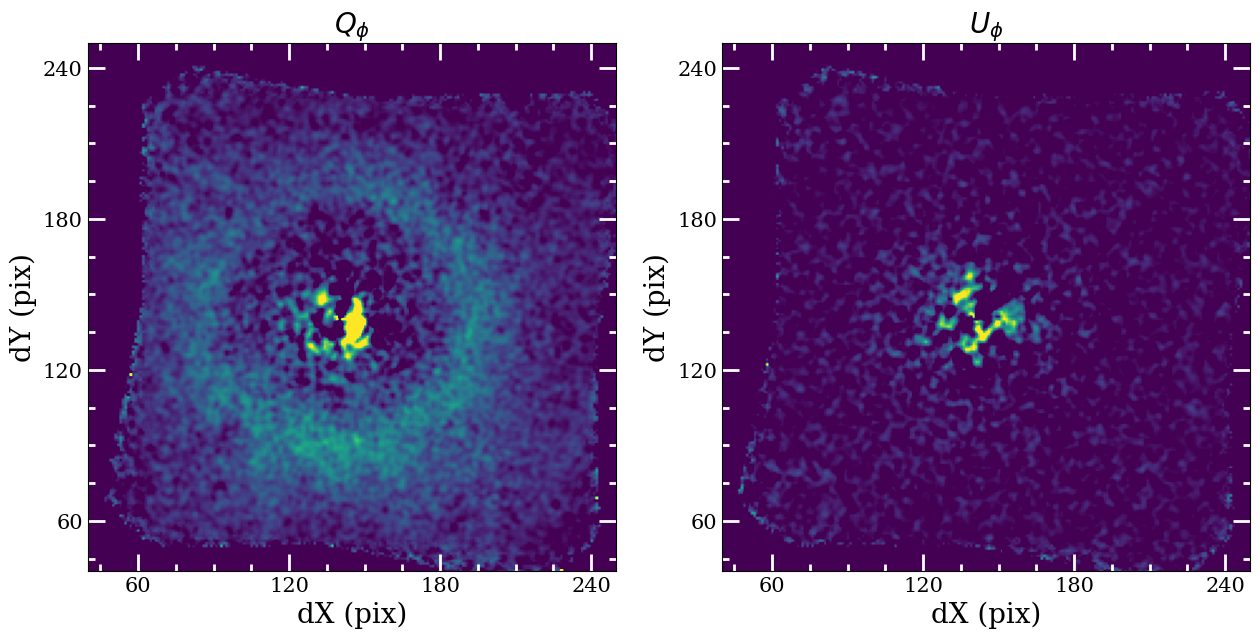

In [3]:
###Plotting our data

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(15, 7)
(ax1, ax2) = axs

ax1.imshow(Qphi, origin='lower',vmin=0,vmax=0.8)
ax1.set_title("$Q_{\phi}$",fontsize=20)

ax2.imshow(Uphi, origin='lower',vmin=0,vmax=0.8)
ax2.set_title("$U_{\phi}$",fontsize=20)

for ax in axs.flat:
    ax.minorticks_on()
    ax.tick_params(which='both', width=2, color='w')
    ax.tick_params(right=True, top=True, which='major', labelsize=15, length=12, direction="in")
    ax.tick_params(which='minor', right=True, top=True, length=5, direction='in')
    ax.set_xlabel('dX (pix)',fontsize=20)
    ax.set_ylabel('dY (pix)',fontsize=20)
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.set_xlim(40,250)
    ax.set_ylim(40,250)

plt.show()

In [4]:
###Mask Qphi

def create_circular_mask(h, w, center=None, radius=None):
    
    if center is None: 
        center = (int(w/2), int(h/2))
    if radius is None: 
        radius = min(center[0], center[1], w-center[0], h-center[1])
    
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center >= radius
    return mask

center = (140,140) 
img = Qphi
h, w = img.shape[:2]
radius = 0.35/0.014166 #<--- Masking using a radius 0.35", feel free to change to whatever.
mask = create_circular_mask(h, w,center=center,radius=radius)
masked_Qphi = img.copy()
masked_Qphi[~mask] = 0

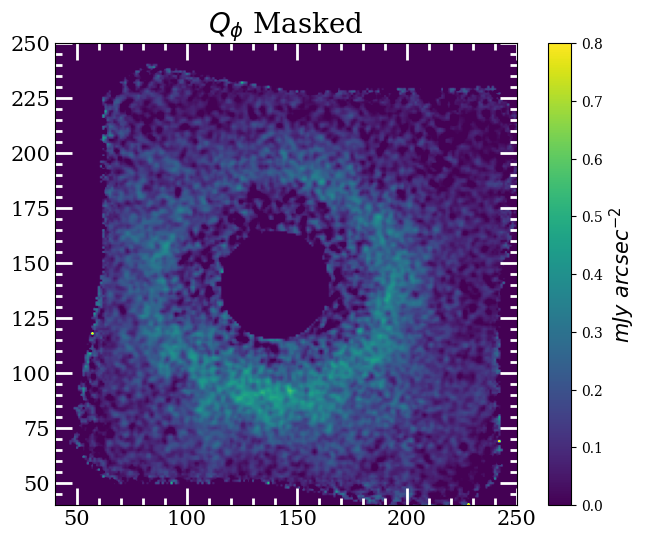

In [5]:
plt.figure(figsize=(8,6))

plt.imshow(masked_Qphi, origin='lower',vmin=0,vmax=0.8)
plt.colorbar().set_label(label='$mJy \ arcsec^{-2}$',fontsize=15)
plt.title("$Q_{\phi}$ Masked",fontsize=20)
plt.xlim(40,250)
plt.ylim(40,250)

plt.minorticks_on()
plt.tick_params(which='both', width=2, color='w')
plt.tick_params(right=True, top=True, which='major', labelsize=15, length=12, direction="in")
plt.tick_params(which='minor', right=True, top=True, length=5, direction='in')

plt.show()

In [6]:
###Create standard deviation map.

def make_radii(arr, cen):
    
    grid = np.indices(arr.shape, dtype=float)
    grid[0] -= cen[0]
    grid[1] -= cen[1]
    return np.sqrt((grid[0])**2 + (grid[1])**2)


def get_ann_stdmap(im, cen, radii, r_max=None, mask_edges=False):
    
    if r_max==None:
        r_max = radii.max()
    
    if mask_edges:
        cen = np.array(im.shape)/2
        mask = np.ma.masked_invalid(gaussian_filter(im, mask_edges)).mask
        mask[cen[0]-mask_edges*5:cen[0]+mask_edges*5, cen[1]-mask_edges*5:cen[1]+mask_edges*5] = False
        im = np.ma.masked_array(im, mask=mask).filled(np.nan)
    
    stdmap = np.zeros(im.shape, dtype=float)
    for rr in np.arange(0, r_max, 1):
        if rr==0:
            wr = np.nonzero((radii >= 0) & (radii < 2))
            stdmap[cen[0], cen[1]] = np.nanstd(im[wr])
        else:
            wr = np.nonzero((radii >= rr-0.5) & (radii < rr+0.5))
            stdmap[wr] = np.nanstd(im[wr])
    return stdmap

star = np.array([140, 140]) 

radii = make_radii(Qphi, star)
Uphi_noise = get_ann_stdmap(Uphi, star, radii, r_max=135)
Uphi_noise[Uphi_noise==0.0] = np.nan

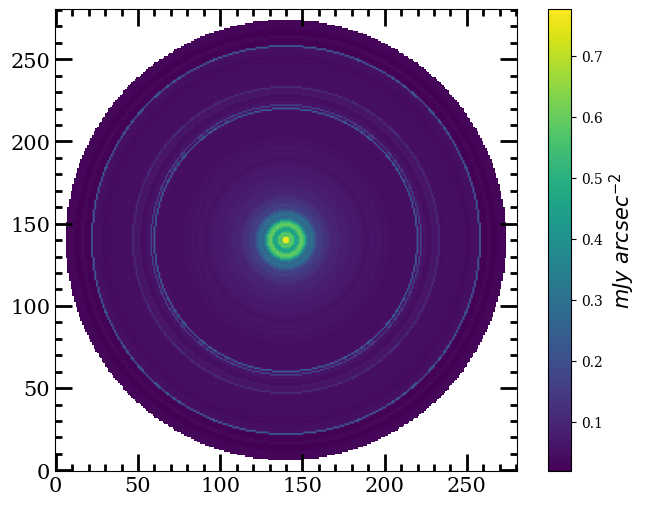

In [7]:
### Plot standard deviation map

plt.figure(figsize=(8,6))

plt.imshow(Uphi_noise, origin='lower')
plt.colorbar().set_label(label='$mJy \ arcsec^{-2}$',fontsize=15)

plt.minorticks_on()
plt.tick_params(which='both', width=2, color='k')
plt.tick_params(right=True, top=True, which='major', labelsize=15, length=12, direction="in")
plt.tick_params(which='minor', right=True, top=True, length=5, direction='in')

plt.show()

In [8]:
###Define the disk PA, PA range and disk inclination.

disk_PA = 91.02 #PA derived in Crotts et al. (2023)
disk_PA = disk_PA - 90 
disk_inc = 15.1 #inclination derived from Crotts et al. (2023)

PA1 = disk_PA - 180
PA2 = disk_PA + 180
PA_range = np.linspace(PA1, PA2, 181)
#Because the full disk is observed, we go from -180 to +180 degrees to cover the entire disk.

In [9]:
###Conduct the Gaussian fitting.

y1 = 64
y2 = 140
sigma_smooth = 4

def gaus(ys,a,b,x0,sigma):
    return a*np.exp(-(ys-x0)**2/(2*sigma**2)) + b 

def prof(xl,Qphi,Uphi_noise,y1,y2):
    br = []
    errs = []
    dy = y2 - y1 + 1
    ys = np.linspace(y1,y2,dy)
    for y in ys:
        int_ys = int(y)
        intens = Qphi[(int_ys,xl)]
        err = Uphi_noise[(int_ys,xl)]
        br.append(intens)
        errs.append(err)
    return br, errs

def gauss_fit(masked_Qphi,Uphi_noise,PA_range,disk_PA,y1,y2,sigma_s=1):
    from scipy.ndimage import zoom
    from scipy.optimize import curve_fit
    from scipy import asarray as ar,exp
    from scipy import ndimage
    import copy
    from scipy.ndimage import gaussian_filter
    
    binned_im = gaussian_filter(masked_Qphi, sigma=sigma_s) 
    
    dy = y2 - y1 + 1
    ys = np.linspace(y1,y2,dy)
    pix_scale = 0.014166 
    center = 140 
    
    fwhm = [] 
    error = [] 
    means = []
    mean_err = [] 
    x_arc = [] 
    for i in PA_range:
        try:
            rotate_image = ndimage.interpolation.rotate(binned_im, i, reshape=False) 
            x = center  
            br, br_errs = prof(x,rotate_image,Uphi_noise,y1,y2)
            n = len(ys)
            int_max_br = np.argmax(br)
            mean = ys[int_max_br]
            sigma_g = np.sqrt(sum((ys-mean)**2)/n) 
            popt,pcov = curve_fit(gaus,ys,br,p0=[1,0,mean,sigma_g],sigma=br_errs) 
        except:
            pass  
        fwhms = np.abs(popt[3]*2.35*pix_scale)  
        perr = np.sqrt(np.diag(pcov))
        fwhm.append(fwhms)
        error.append(perr[3]*2.35*pix_scale) 
        rad = popt[2] - center
        PA_rad = np.deg2rad(disk_PA - i)
        mean_cart = rad - (rad - rad*np.cos(PA_rad)) 
        mean_arc = mean_cart*pix_scale 
        means.append(mean_arc)
        mean_err.append(perr[2]*pix_scale)
        xs = center + rad*np.sin(PA_rad)
        x_arcs = xs*pix_scale - 2
        x_arc.append(x_arcs) 
    return np.array(fwhm), np.array(error), np.array(means), np.array(mean_err), np.array(x_arc)

#Calculating the fwhm and mean profiles.
fwhm, fwhm_err, mean, mean_err, x_arc = gauss_fit(masked_Qphi,Uphi_noise,PA_range,disk_PA,y1,y2,sigma_smooth)

In [10]:
###Removing noisy data points.

mean2 = []
mean_err2 = []
x_arc2 = []
for i in range(len(fwhm)):
    if np.abs(fwhm[i]) > 3*np.abs(fwhm_err[i]):
        x_arc2.append(x_arc[i])
        mean2.append(mean[i])
        mean_err2.append(mean_err[i])

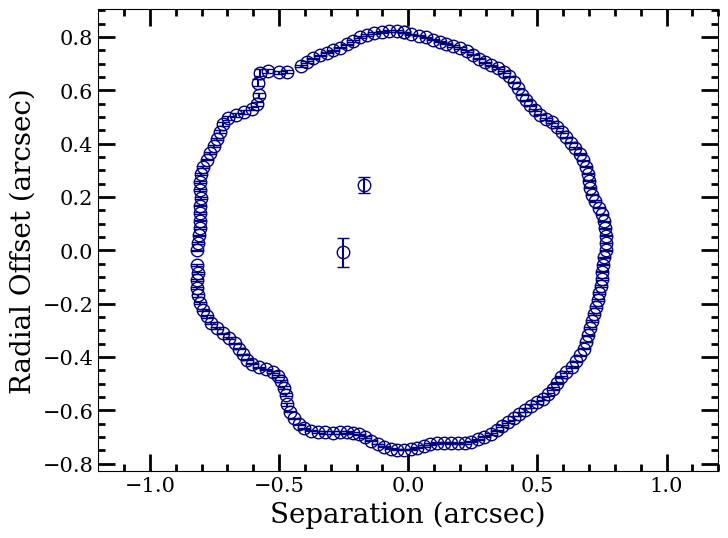

In [11]:
###Plotting the mean profile (i.e. the disk spine)

plt.figure(figsize=(8,6))

plt.errorbar(x_arc2, mean2, yerr=(mean_err2),color='navy',fmt='o',mfc='None',ecolor='navy', capsize=4, markersize=9)

plt.xlim(-1.2,1.2)
plt.xlabel('Separation (arcsec)',fontsize=20)
plt.ylabel("Radial Offset (arcsec)",fontsize=20)

plt.minorticks_on()
plt.tick_params(which='both', width=2)
plt.tick_params(right=True, top=True, which='major', labelsize=15, length=12, direction="in")
plt.tick_params(which='minor', right=True, top=True, length=5, direction='in')

plt.show()

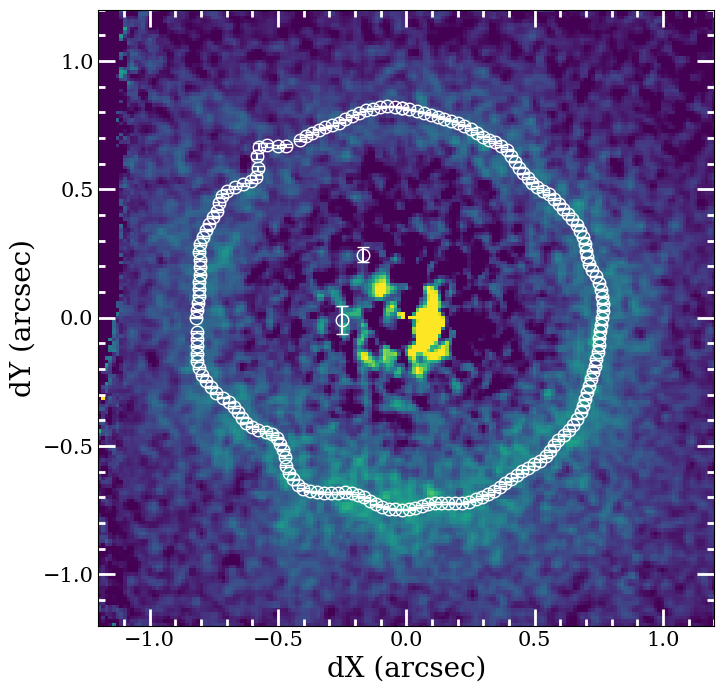

In [12]:
###Disk spine overlaid on Qphi data.

plt.figure(figsize=(10,8))

plt.imshow(Qphi,origin='lower',extent=[-2,2,-2,2],vmin=0,vmax=0.8)
plt.errorbar(x_arc2, mean2, yerr=(mean_err2),color='w',fmt='o',mfc='None',ecolor='w', capsize=4, markersize=9)

plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.xlabel('dX (arcsec)',fontsize=20)
plt.ylabel("dY (arcsec)",fontsize=20)

plt.minorticks_on()
plt.tick_params(which='both', width=2,color='w')
plt.tick_params(right=True, top=True, which='major', labelsize=15, length=12, direction="in")
plt.tick_params(which='minor', right=True, top=True, length=5, direction='in')

plt.show()

In [13]:
###Creating best fitting ellipse model.

def ring_model(rad_ring,ring_offset,y_offset,inc_ring,rads):
    
    theta=np.linspace(0,900,901)/5.
    
    xx=rad_ring*np.cos(theta*np.pi/180.)+ring_offset
    yy=rad_ring*np.sin(theta*np.pi/180.)*np.cos(inc_ring*np.pi/180.) + y_offset
    
    spine_models=[]
    
    for i in range(len(rads)):
        if (rads[i] < np.min(xx)) or (rads[i] > np.max(xx)):
            spine_model=0.0+y_offset
            spine_models.append(spine_model)
        else:
            spine_model=np.interp(rads[i],xx,yy,period=360)
            spine_models.append(spine_model)
    return spine_models

rads = np.linspace(-2,2,201)

model = ring_model(0.797, -0.025, 0.025, 164.9, rads) #<---- These values were derived in Crotts et al. (2023)

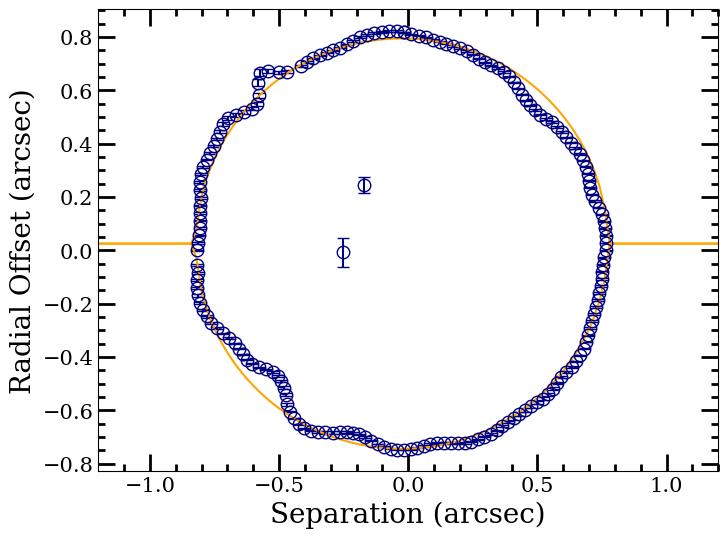

In [14]:
###Overlay ring model on the disk spine.

plt.figure(figsize=(8,6))

plt.errorbar(x_arc2, mean2, yerr=(mean_err2),color='navy',fmt='o',mfc='None',ecolor='navy', capsize=4, markersize=9)
plt.plot(rads,model,color='orange')
plt.plot(rads,-np.array(model)+0.05,color='orange') #<---Flipping the ring model over the y-axis to fit the backside of the disk. 0.05 = 2*y_offset.

plt.xlim(-1.2,1.2)
plt.xlabel('Separation (arcsec)',fontsize=20)
plt.ylabel("Radial Offset (arcsec)",fontsize=20)

plt.minorticks_on()
plt.tick_params(which='both', width=2)
plt.tick_params(right=True, top=True, which='major', labelsize=15, length=12, direction="in")
plt.tick_params(which='minor', right=True, top=True, length=5, direction='in')

plt.show()

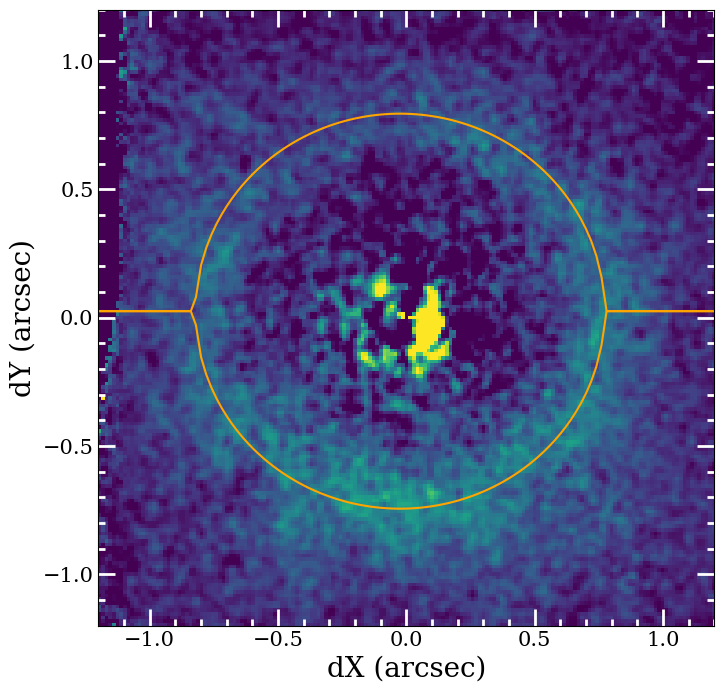

In [15]:
plt.figure(figsize=(10,8))

plt.imshow(Qphi,origin='lower',extent=[-2,2,-2,2],vmin=0,vmax=0.8)
plt.plot(rads,model,color='orange')
plt.plot(rads,-np.array(model)+0.05,color='orange')

plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.xlabel('dX (arcsec)',fontsize=20)
plt.ylabel("dY (arcsec)",fontsize=20)

plt.minorticks_on()
plt.tick_params(which='both', width=2,color='w')
plt.tick_params(right=True, top=True, which='major', labelsize=15, length=12, direction="in")
plt.tick_params(which='minor', right=True, top=True, length=5, direction='in')

plt.show()

### What is the process for the Gaussian fitting procedure exactly?

In order to extract the disk spine, we need to fit a Gaussian profile to the radial surface brightness at various locations along the disk. We can then extract the mean of the Gaussian, which represents the disk spine location at that particular point on the disk. For low inclined disks (i $\lesssim$ 70$^{\circ}$), a different method is required to measure the disk spine compared to higher inclined disks, as we are probing the radial structure rather than the vertical structure. To do this, I came up with a method which consists of rotating the image and taking vertical slices across the disk for each rotation. 

In [16]:
###Rotating the image by different angles.

rot1_Qphi = ndimage.interpolation.rotate(masked_Qphi, disk_PA-90, reshape=False)
rot2_Qphi = ndimage.interpolation.rotate(masked_Qphi, disk_PA, reshape=False) #disk_PA = 1 degree for TWA 7. 
rot3_Qphi = ndimage.interpolation.rotate(masked_Qphi, disk_PA+90, reshape=False)

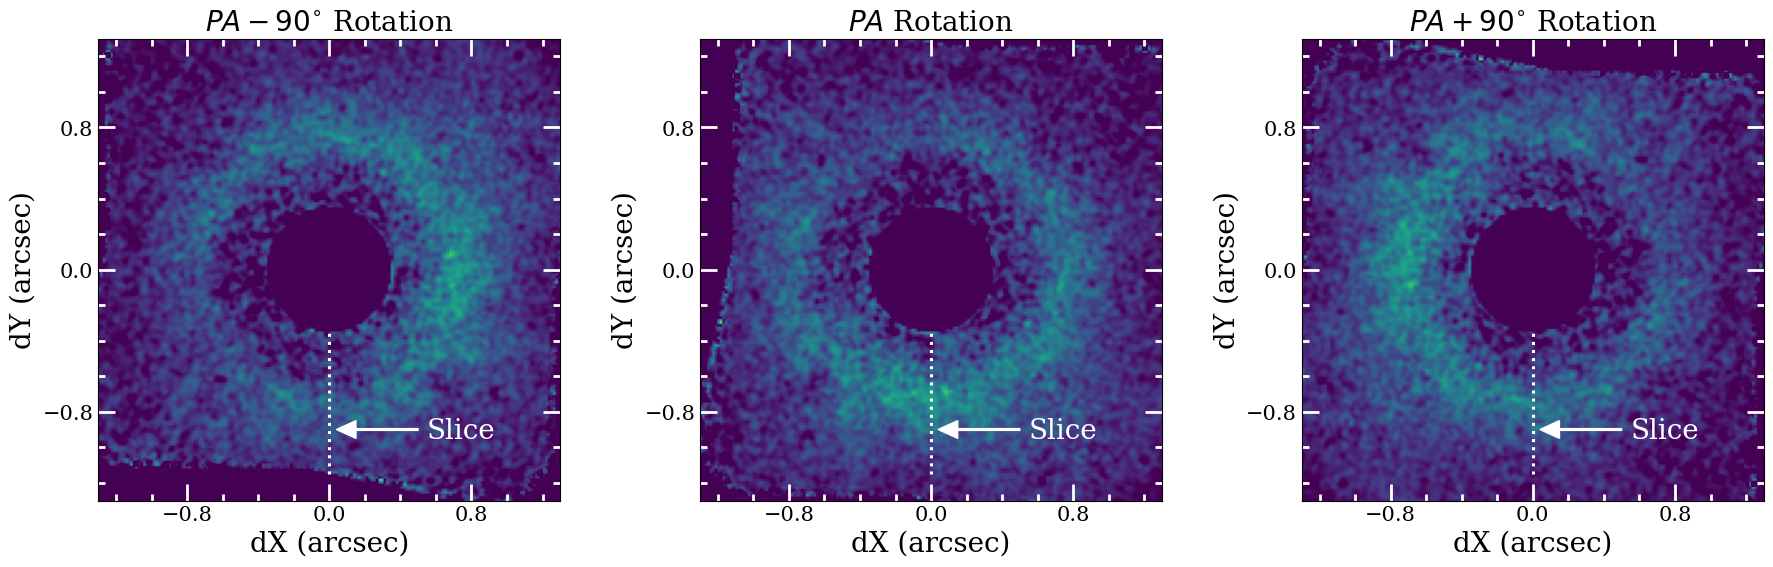

In [17]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(22, 6)
(ax1, ax2, ax3) = axs

ax1.imshow(rot1_Qphi, origin='lower', vmin=0,vmax=0.8, extent=[-2,2,-2,2])
ax1.set_title("$PA-90^{\circ}$ Rotation",fontsize=20)

ax2.imshow(rot2_Qphi, origin='lower', vmin=0,vmax=0.8, extent=[-2,2,-2,2])
ax2.set_title("$PA$ Rotation",fontsize=20)

ax3.imshow(rot3_Qphi, origin='lower', vmin=0,vmax=0.8, extent=[-2,2,-2,2])
ax3.set_title("$PA+90^{\circ}$ Rotation",fontsize=20)

for ax in axs.flat:
    ax.minorticks_on()
    ax.tick_params(which='both', width=2, color='w')
    ax.tick_params(right=True, top=True, which='major', labelsize=15, length=12, direction="in")
    ax.tick_params(which='minor', right=True, top=True, length=5, direction='in')
    ax.set_xlabel('dX (arcsec)',fontsize=20)
    ax.set_ylabel('dY (arcsec)',fontsize=20)
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.set_xlim(-1.3,1.3)
    ax.set_ylim(-1.3,1.3)
    ax.vlines(x=0,ymin=-1.15,ymax=-0.35,color='w',linestyle=':',linewidth=2.2)
    ax.arrow(0.5,-0.9,-0.35,0,color='w',width=.01,head_width=0.1,head_length=0.11)
    ax.text(0.55,-0.95, "Slice", color='w', fontsize=20)

plt.show()

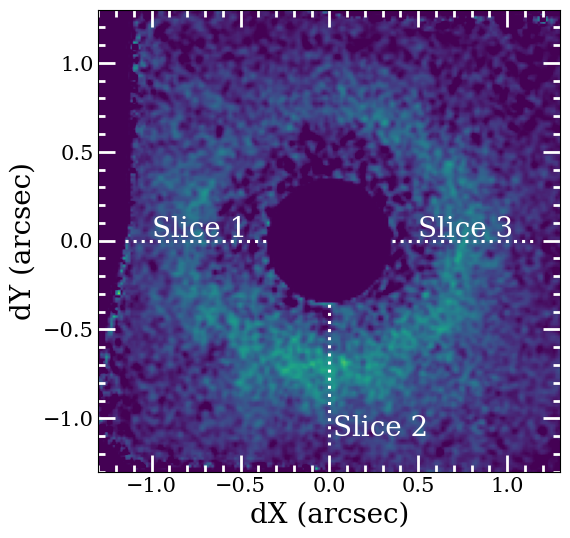

In [18]:
plt.figure(figsize=(8,6))

plt.imshow(rot2_Qphi,origin='lower',extent=[-2,2,-2,2],vmin=0,vmax=0.8)

plt.xlim(-1.3,1.3)
plt.ylim(-1.3,1.3)
plt.xlabel('dX (arcsec)',fontsize=20)
plt.ylabel("dY (arcsec)",fontsize=20)

plt.vlines(x=0,ymin=-1.15,ymax=-0.35,color='w',linestyle=':',linewidth=2.2)
plt.hlines(y=0,xmin=-1.15,xmax=-0.35,color='w',linestyle=':',linewidth=2.2)
plt.hlines(y=0,xmin=0.35,xmax=1.15,color='w',linestyle=':',linewidth=2.2)

plt.text(-1,0.02, "Slice 1", color='w', fontsize=20)
plt.text(0.02,-1.1, "Slice 2", color='w', fontsize=20)
plt.text(0.5,0.02, "Slice 3", color='w', fontsize=20)

plt.minorticks_on()
plt.tick_params(which='both', width=2,color='w')
plt.tick_params(right=True, top=True, which='major', labelsize=15, length=12, direction="in")
plt.tick_params(which='minor', right=True, top=True, length=5, direction='in')

plt.show()

The above example shows slices being made at three different angles after the image is rotated. This process is done for multiple angles to cover the entire disk. The surface brightness is then measured along each slice, and the Gaussian profile is fit to the surface brightness. From here the mean of the Gaussian can be measured, representing the peak surface brightness location or disk spine.